<a href="https://colab.research.google.com/github/shubham3032002/car_detection_system_using_yolo8/blob/main/car_detection_system_using_yolo8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.9/932.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import kagglehub
import shutil
save_path='/content/'
# Download latest version
path = kagglehub.dataset_download("sshikamaru/car-object-detection")
shutil.move(path,save_path)
print("Path to dataset files:", path)

100%|██████████| 112M/112M [00:00<00:00, 161MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sshikamaru/car-object-detection/versions/2


In [3]:
import os
import shutil
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
data = pd.read_csv("/content/dataset/data/train_solution_bounding_boxes (1).csv")

In [5]:
train_img_dir = '/content/dataset/data/training_images'
test_img_dir = '/content/dataset/data/testing_images'



In [6]:
output_dir = '/content/working/dataset'

In [7]:
for data_type in ["images", "labels"]:
    for subset in ["train", "test", "val"]:
        os.makedirs(os.path.join(output_dir, data_type, subset), exist_ok=True)

In [8]:
def gen_annot(df, folder):
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f'Processing {folder} set'):
        name = row['image']
        xmin, ymin, xmax, ymax = row.get('xmin', 0), row.get('ymin', 0), row.get('xmax', 0), row.get('ymax', 0)

        w, h = xmax - xmin, ymax - ymin
        c_x, c_y = xmin + w / 2, ymin + h / 2

        image_path = os.path.join(train_img_dir, name)
        if not os.path.exists(image_path):
            continue

        with Image.open(image_path) as img:
            img_w, img_h = img.size

        c_x /= img_w
        c_y /= img_h
        w /= img_w
        h /= img_h

        # Class ID (assuming only 'car')
        class_id = 0
        annot = f"{class_id} {c_x} {c_y} {w} {h}\n"

        annot_file = os.path.join(output_dir, 'labels', folder, os.path.splitext(name)[0] + '.txt')
        with open(annot_file, 'a') as file:
            file.write(annot)

        shutil.copy(image_path, os.path.join(output_dir, 'images', folder, name))

In [9]:
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


In [10]:
gen_annot(train_df, 'train')
gen_annot(val_df, 'val')

Processing val set: 100%|██████████| 112/112 [00:00<00:00, 1119.23it/s]


In [11]:
for img in tqdm(os.listdir(test_img_dir), desc='Copying test images'):
    shutil.copy(os.path.join(test_img_dir, img), os.path.join(output_dir, 'images', 'test', img))

Copying test images: 100%|██████████| 175/175 [00:00<00:00, 5819.10it/s]


In [12]:
yaml_content = f"""
path: /content/working/
train: ../dataset/images/train/
val: ../dataset/images/val/
test: ../dataset/images/test/

nc: 1
names: ['car']
"""

In [13]:
with open('car_detection.yaml', 'w') as file:
    file.write(yaml_content)

In [14]:
model = YOLO("yolov8n.pt")
results = model.train(data='car_detection.yaml', epochs=50, imgsz=640, batch=16, name='car_detection_model')


100%|██████████| 6.25M/6.25M [00:00<00:00, 109MB/s]


Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=car_detection.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=car_detection_model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

100%|██████████| 755k/755k [00:00<00:00, 23.4MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 99.5MB/s]


AMP: checks passed ✅


train: Scanning /content/working/dataset/labels/train... 307 images, 0 backgrounds, 0 corrupt: 100%|██████████| 307/307 [00:00<00:00, 2279.45it/s]

train: New cache created: /content/working/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/working/dataset/labels/val... 94 images, 0 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<00:00, 1882.44it/s]

val: New cache created: /content/working/dataset/labels/val.cache


Plotting labels to runs/detect/car_detection_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/car_detection_model
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.09G      1.538      2.681      1.149          7        640: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         94        112    0.00397          1      0.642      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.18G      1.301      1.489      1.099         11        640: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


                   all         94        112    0.00397          1      0.451      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.19G      1.326      1.377      1.106          8        640: 100%|██████████| 20/20 [00:04<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         94        112      0.619      0.321      0.446      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.19G      1.289      1.236      1.097          9        640: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

                   all         94        112      0.512      0.438      0.452      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.19G      1.281      1.196        1.1          7        640: 100%|██████████| 20/20 [00:04<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         94        112      0.565       0.83      0.601      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.19G      1.279      1.156      1.081         12        640: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         94        112      0.557      0.921      0.704      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.19G       1.25       1.09      1.101         11        640: 100%|██████████| 20/20 [00:04<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         94        112      0.539      0.893      0.564      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.19G      1.272      1.052      1.087         10        640: 100%|██████████| 20/20 [00:04<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]

                   all         94        112      0.587      0.887      0.678      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.19G      1.241      1.009      1.095         13        640: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         94        112      0.572      0.884      0.653      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.19G      1.247     0.9282       1.07          5        640: 100%|██████████| 20/20 [00:04<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.57it/s]

                   all         94        112      0.561      0.804      0.609      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.19G      1.236     0.9316      1.063         12        640: 100%|██████████| 20/20 [00:04<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         94        112      0.575      0.946       0.63      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.19G      1.223     0.8642      1.072          9        640: 100%|██████████| 20/20 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         94        112      0.561      0.982      0.619        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.19G      1.256     0.8945      1.076         12        640: 100%|██████████| 20/20 [00:04<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         94        112       0.59      0.929      0.652      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.19G      1.174     0.8229      1.062          9        640: 100%|██████████| 20/20 [00:05<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         94        112       0.58      0.929      0.594      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.19G      1.239     0.8391      1.073         15        640: 100%|██████████| 20/20 [00:04<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.17it/s]

                   all         94        112      0.575      0.942      0.609      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.19G      1.231     0.8431      1.091          4        640: 100%|██████████| 20/20 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

                   all         94        112      0.556      0.961        0.6      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.19G       1.17     0.8057      1.053         12        640: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         94        112       0.56      0.991      0.597      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.19G       1.19     0.7925      1.073          6        640: 100%|██████████| 20/20 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         94        112      0.576      0.946      0.597      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.19G      1.143     0.7702      1.072          4        640: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]

                   all         94        112      0.583      0.922      0.657      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.19G      1.182     0.7706      1.078          7        640: 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         94        112      0.568      0.973      0.632       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.19G      1.143     0.7397      1.036         13        640: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

                   all         94        112      0.583      0.955      0.642      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.19G      1.125       0.69      1.038          7        640: 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]

                   all         94        112      0.574      0.955      0.674      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.19G      1.116     0.7235       1.04          6        640: 100%|██████████| 20/20 [00:04<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]

                   all         94        112      0.572      0.955       0.62      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.19G      1.124     0.7128      1.023          6        640: 100%|██████████| 20/20 [00:05<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

                   all         94        112      0.551      0.986      0.626      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.19G      1.084     0.7177      1.016          6        640: 100%|██████████| 20/20 [00:04<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]

                   all         94        112      0.558      0.982      0.584      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.19G      1.115     0.6905      1.037          8        640: 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

                   all         94        112      0.578      0.911      0.652      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.19G       1.12     0.7298      1.039          6        640: 100%|██████████| 20/20 [00:04<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]

                   all         94        112       0.57      0.899       0.63      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.19G      1.079     0.6377      1.018          7        640: 100%|██████████| 20/20 [00:05<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]

                   all         94        112      0.556      0.929       0.61      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.19G      1.071     0.6594      1.009         11        640: 100%|██████████| 20/20 [00:04<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]

                   all         94        112      0.571      0.964      0.654      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.19G       1.05     0.6486      1.011          4        640: 100%|██████████| 20/20 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]

                   all         94        112      0.565      0.946      0.627      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.19G      1.071     0.6472      1.007         11        640: 100%|██████████| 20/20 [00:04<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.27it/s]

                   all         94        112       0.55      0.938      0.614      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.19G      1.048     0.6253     0.9966         13        640: 100%|██████████| 20/20 [00:05<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]

                   all         94        112      0.551      0.946      0.655      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.19G      1.047     0.6306      1.002         13        640: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         94        112      0.542      0.991      0.647       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.19G      1.017     0.6359     0.9933          5        640: 100%|██████████| 20/20 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         94        112      0.551      0.982      0.575      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.19G      1.026     0.5963      0.986          8        640: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]

                   all         94        112      0.565      0.911      0.587        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.19G      1.026     0.5867      1.006          3        640: 100%|██████████| 20/20 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         94        112      0.544      0.955      0.645      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.19G      1.017      0.587     0.9871         15        640: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

                   all         94        112      0.537      0.991      0.604      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.19G     0.9893     0.5947     0.9901          5        640: 100%|██████████| 20/20 [00:05<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         94        112      0.536      0.964      0.613      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.19G      1.021     0.5961      1.002          6        640: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


                   all         94        112      0.552      0.945       0.62      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.19G     0.9745     0.5725     0.9856         10        640: 100%|██████████| 20/20 [00:04<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         94        112      0.551      0.929      0.588      0.404


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.19G     0.9931     0.5995     0.9902          4        640: 100%|██████████| 20/20 [00:05<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]

                   all         94        112      0.541      0.946      0.632      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.19G     0.9875     0.6026     0.9816          4        640: 100%|██████████| 20/20 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         94        112      0.556      0.982      0.659      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.19G     0.9893     0.5841      0.997          4        640: 100%|██████████| 20/20 [00:04<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]

                   all         94        112      0.562      0.991      0.616      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.19G      0.972     0.5818     0.9915          6        640: 100%|██████████| 20/20 [00:04<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         94        112       0.55      0.991      0.624      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.19G     0.9561     0.5738     0.9685          4        640: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]

                   all         94        112      0.549      0.982      0.623      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.19G     0.9319     0.5605     0.9683          5        640: 100%|██████████| 20/20 [00:04<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         94        112      0.549       0.98      0.611      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.19G      0.931     0.5606     0.9778          3        640: 100%|██████████| 20/20 [00:04<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]


                   all         94        112      0.537      0.964      0.589        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.19G     0.9459     0.5437     0.9806          4        640: 100%|██████████| 20/20 [00:04<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

                   all         94        112      0.549      0.935      0.601      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.19G     0.9503     0.5525     0.9831          3        640: 100%|██████████| 20/20 [00:05<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

                   all         94        112      0.548      0.932      0.611       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.19G       0.91     0.5357     0.9554          3        640: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]

                   all         94        112      0.548      0.932      0.621       0.43



50 epochs completed in 0.089 hours.
Optimizer stripped from runs/detect/car_detection_model/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/car_detection_model/weights/best.pt, 6.2MB

Validating runs/detect/car_detection_model/weights/best.pt...
Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


                   all         94        112      0.554       0.92      0.704      0.432
Speed: 0.3ms preprocess, 1.9ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/detect/car_detection_model


In [15]:
evaluations = model.val()

Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/working/dataset/labels/val.cache... 94 images, 0 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


                   all         94        112      0.557       0.92      0.704      0.435
Speed: 2.5ms preprocess, 5.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/car_detection_model2


In [19]:
def plot_graphs(graphs, size):
    plt.figure(figsize=(15, 10))
    for idx, graph in enumerate(graphs, start=1):
        plt.subplot(size[0], size[1], idx)
        graph_path = os.path.join('/content/runs/detect/car_detection_model/', graph)
        if os.path.exists(graph_path):
            plt.imshow(plt.imread(graph_path))
        plt.axis("off")
    plt.show()

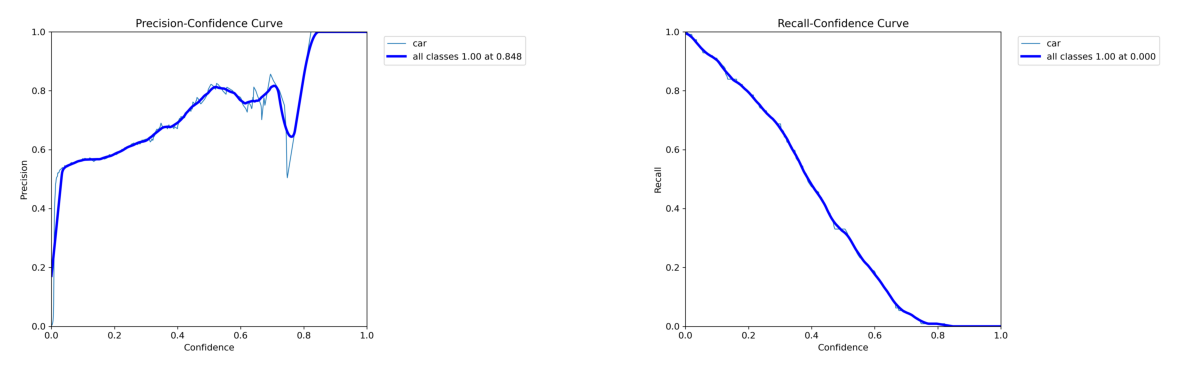

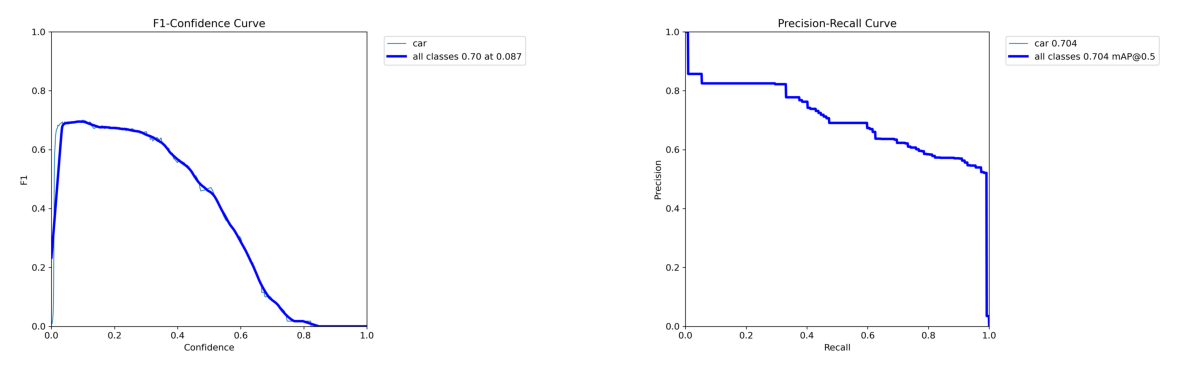

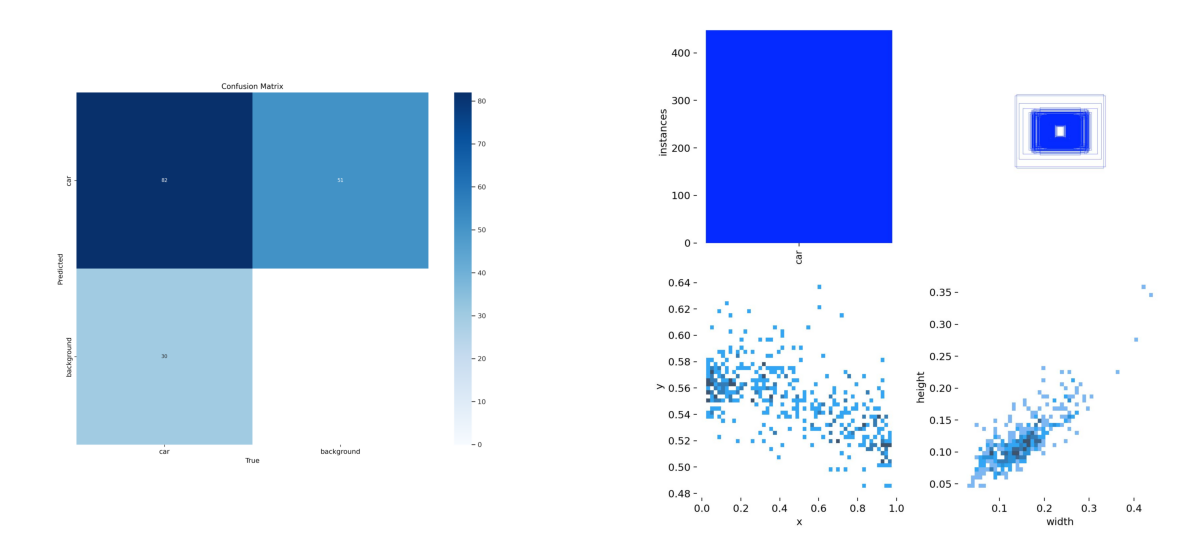

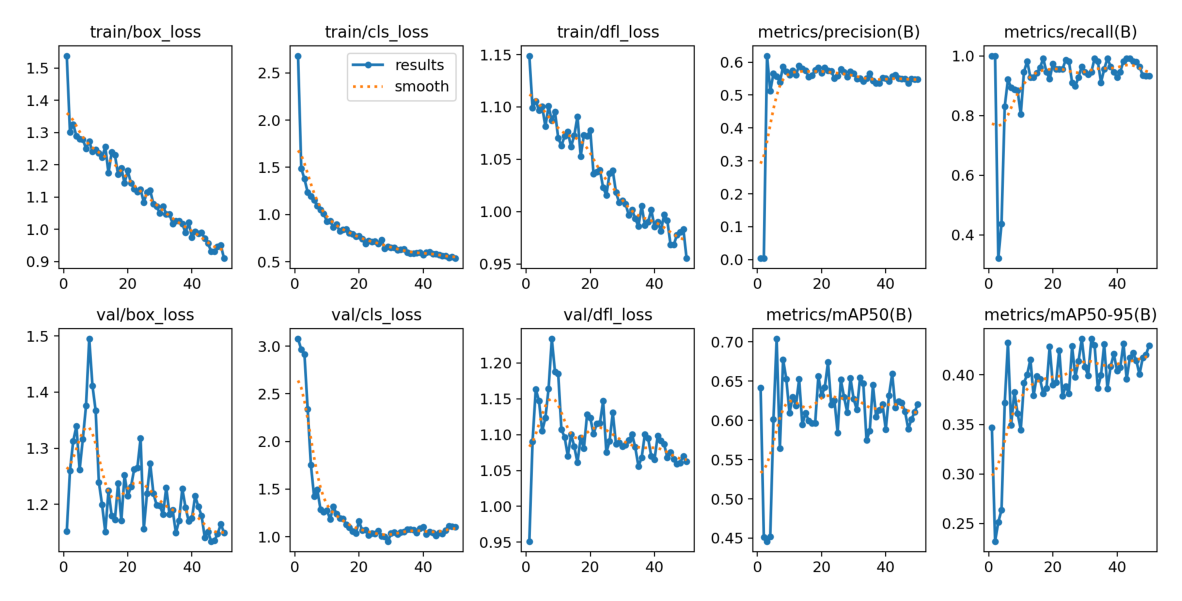

In [20]:
plot_graphs(['P_curve.png', 'R_curve.png'], (1, 2))
plot_graphs(['F1_curve.png', 'PR_curve.png'], (1, 2))
plot_graphs(['confusion_matrix.png', 'labels.jpg'], (1, 2))
plot_graphs(['results.png'], (1, 1))


image 1/1 /content/working/dataset/images/test/vid_5_400.jpg: 384x640 (no detections), 37.3ms
Speed: 2.3ms preprocess, 37.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


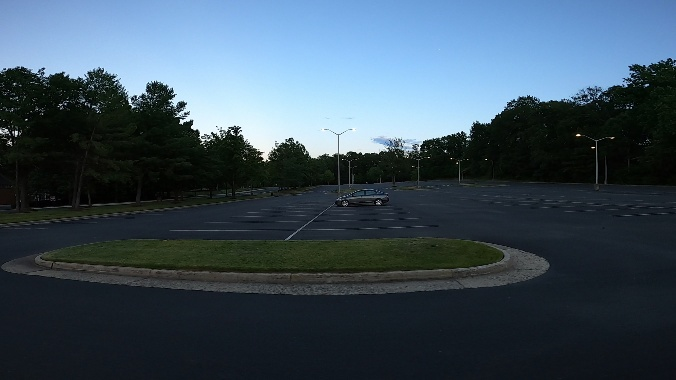


image 1/1 /content/working/dataset/images/test/vid_5_28540.jpg: 384x640 (no detections), 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


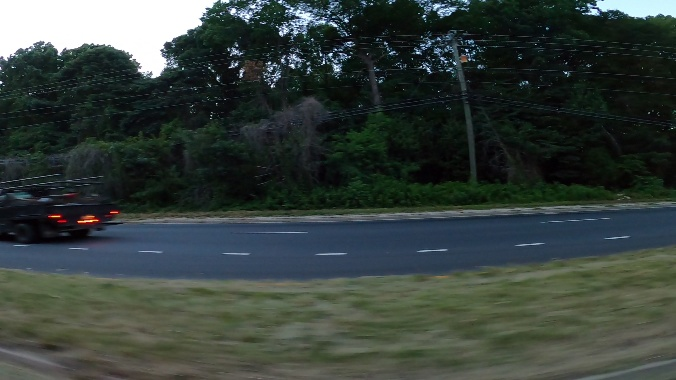


image 1/1 /content/working/dataset/images/test/vid_5_26880.jpg: 384x640 1 car, 11.9ms
Speed: 2.9ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


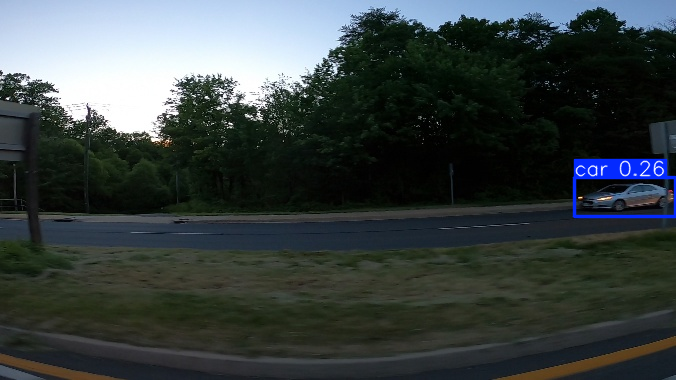


image 1/1 /content/working/dataset/images/test/vid_5_28320.jpg: 384x640 (no detections), 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


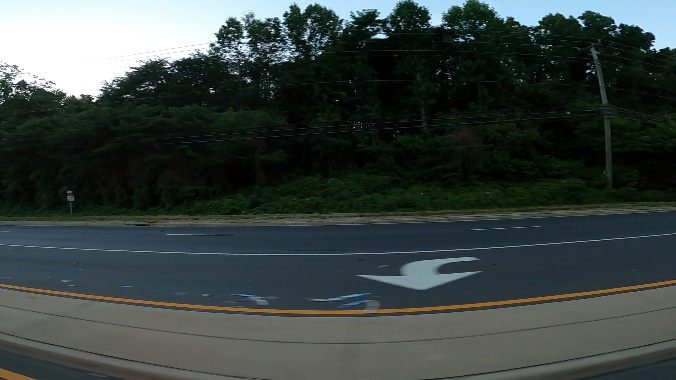


image 1/1 /content/working/dataset/images/test/vid_5_29000.jpg: 384x640 2 cars, 10.5ms
Speed: 2.8ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


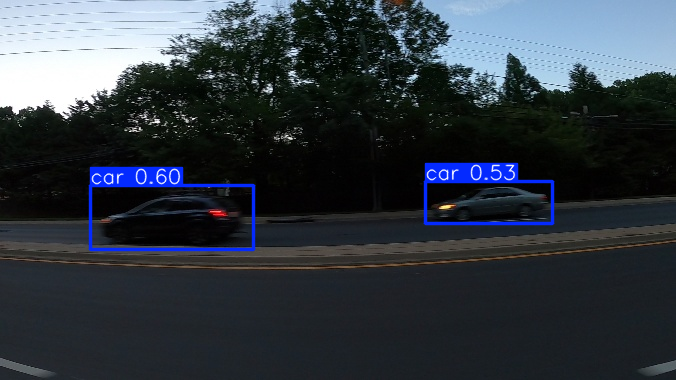

<Figure size 1000x800 with 0 Axes>

In [21]:
plt.figure(figsize=(10, 8))
test_imgs = random.sample(os.listdir(os.path.join(output_dir, 'images/test/')), 5)
for img in test_imgs:
    preds = model(os.path.join(output_dir, 'images/test/', img))
    preds[0].show()